##  Data Processing Pipeline

This notebook performs text data cleaning and preprocessing for a news article classification task. It includes tokenization, lowercasing, stopword removal, contraction expansion, and lemmatization. The processed text is stored in a new column (`PROCESSED_CONTENT`) and the dataset is balanced across four categories: Health, Business, Technology, and Entertainment. Visualizations such as word frequencies, bigrams, and word clouds are used to explore the dataset.


**1. SETUP & CONFIGURATION**

In [49]:
# Core libraries
import pandas as pd
import re
import string
from sklearn.utils import resample
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from nltk.util import ngrams
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Download NLTK data (run once)
nltk.download(['punkt', 'wordnet', 'stopwords', 'omw-1.4', 'punkt_tab'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
input_csv = "/content/drive/MyDrive/new_dataset.csv"
output_csv = "/content/drive/MyDrive/processed_data.csv"

In [52]:
df = pd.read_csv(input_csv)
df.head()

,CATEGORY,CONTENT
0,business,The Federal Reserve approved Ally Financial In...
1,business,— Major shareholders of Duke Energy Corp. have...
2,business,Photos taken earlier this month show that Nort...
3,business,Thanks to dogged reporting by the Associated P...
4,business,The energy giant says it is committed to clean...


#**Plotting the distribution of Categories to see if the dataset is balanced**

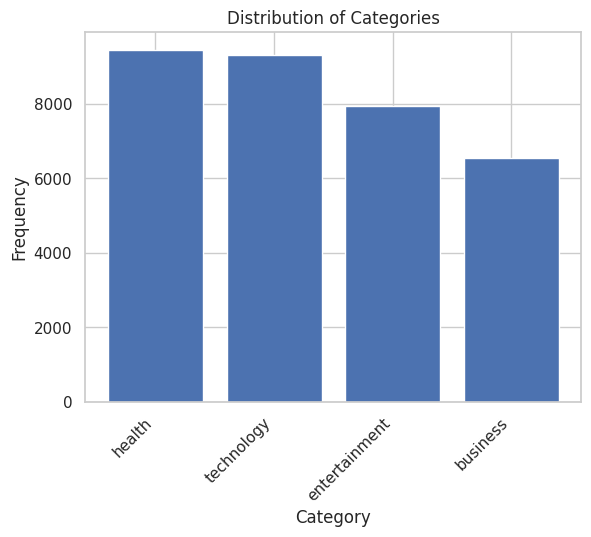

In [67]:
# Extract category labels and frequencies
categories = df['CATEGORY'].value_counts().index
frequencies = df['CATEGORY'].value_counts().values

# Create the bar plot
plt.bar(categories, frequencies)  # Provide both x and height arguments

# Customize the plot (optional)
plt.xlabel("Category")
plt.ylabel("Frequency")
plt.title("Distribution of Categories before sampling")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for readability

plt.show()

In [69]:
df.drop_duplicates(inplace=True)

**PREPROCESSING**

In [53]:
# 1. Preprocessing (without stopword removal)
def preprocess_text(text):
    # Basic cleaning (keep stopwords)
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation but keep words
    return text

# Apply preprocessing
df['CLEANED_CONTENT'] = df['CONTENT'].apply(preprocess_text)

# 2. Get all tokens
all_tokens = []
for text in df['CLEANED_CONTENT']:
    all_tokens.extend(word_tokenize(text))


#**Top 20 most frequent words**

<ipython-input-54-9211b182521a>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=list(counts), y=list(words), palette="viridis")


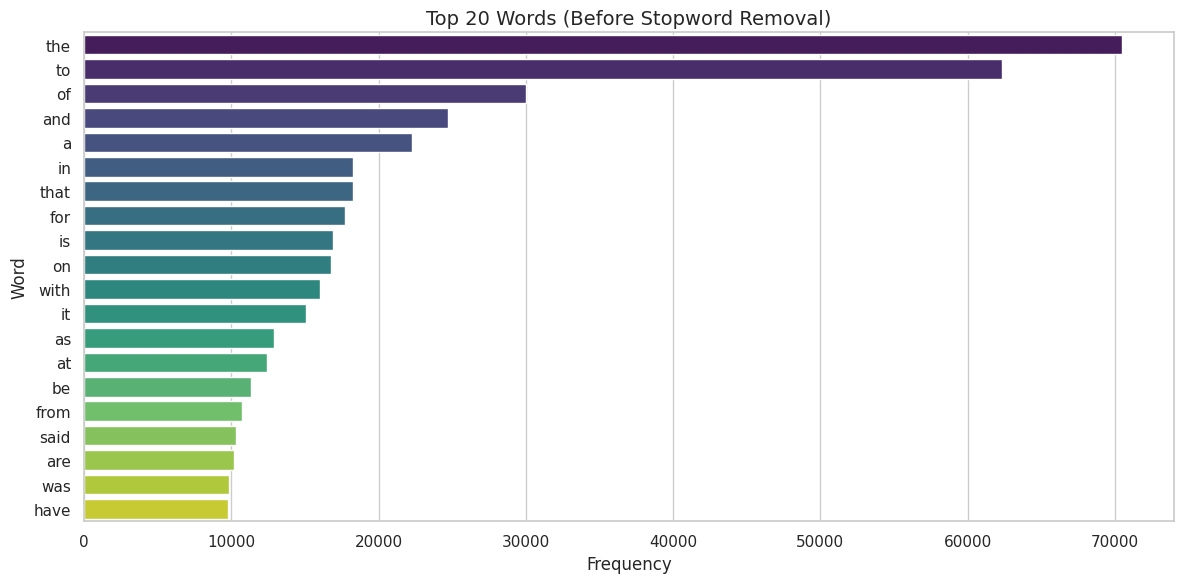

In [54]:
# Count and extract top 20 most common words
word_counts = Counter(all_tokens)
top_words = word_counts.most_common(20)
sns.set(style="whitegrid")

# Create figure
plt.figure(figsize=(12, 6))
barplot = sns.barplot(x=list(counts), y=list(words), palette="viridis")

# Customize the plot
plt.title('Top 20 Words (Before Stopword Removal)', fontsize=14)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Word', fontsize=12)
plt.tight_layout()
plt.show()


#**Visuzlizing the top 20 bigrams**

<ipython-input-55-23fbbeed5983>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=bigram_labels, x=counts, palette="viridis")  # Horizontal bars


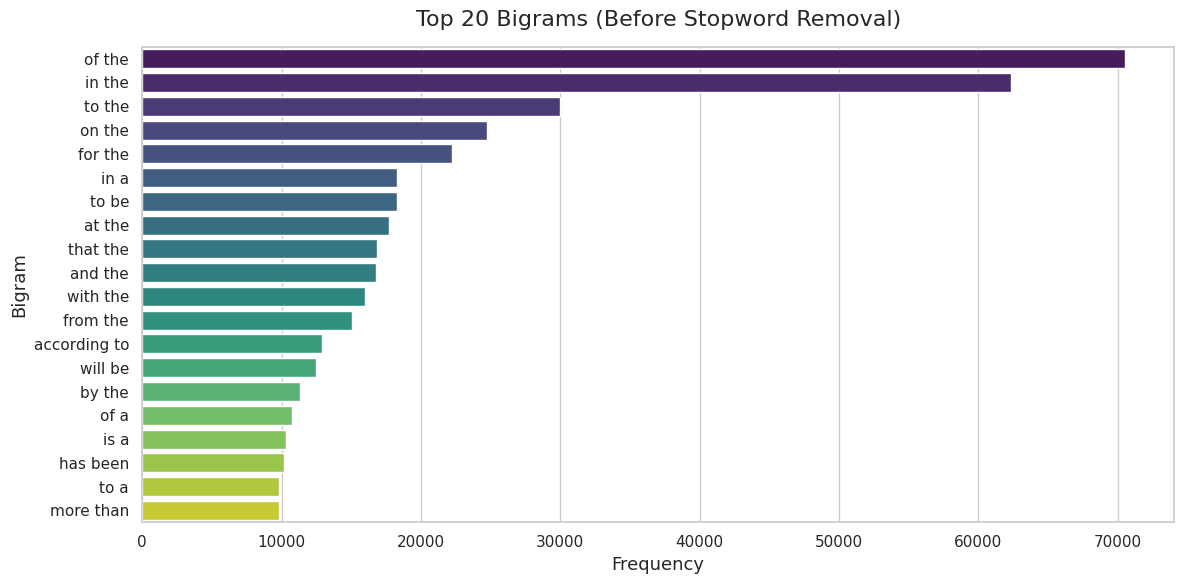

In [55]:
bigrams = ngrams(all_tokens, 2)
bigram_counts = Counter(bigrams)
top_bigrams = bigram_counts.most_common(20)

# Prepare data
bigram_labels = [' '.join(bigram) for bigram, _ in top_bigrams]
counts = [count for _, count in top_bigrams]

# Set Seaborn style
sns.set(style="whitegrid")

# Create figure
plt.figure(figsize=(12, 6))
sns.barplot(y=bigram_labels, x=counts, palette="viridis")  # Horizontal bars

# Customize plot
plt.title('Top 20 Bigrams (Before Stopword Removal)', fontsize=16, pad=15)
plt.xlabel('Frequency', fontsize=13)
plt.ylabel('Bigram', fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()

#**Lemmatizing, contraction expansion and removing stopwords**

In [56]:
# Initialize tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
punct_pattern = re.compile(f'[{re.escape(string.punctuation)}]')

# Contraction mapping
CONTRACTION_MAP = {
    "ain't": "am not", "aren't": "are not", "can't": "cannot",
    "could've": "could have", "couldn't": "could not",
    "didn't": "did not", "doesn't": "does not", "don't": "do not",
    "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
    "he'd": "he would", "he'll": "he will", "he's": "he is",
    "how'd": "how did", "how'll": "how will", "how's": "how is",
    "i'd": "i would", "i'll": "i will", "i'm": "i am",
    "i've": "i have", "isn't": "is not", "it'd": "it would",
    "it'll": "it will", "it's": "it is", "let's": "let us",
    "ma'am": "madam", "might've": "might have", "mightn't": "might not",
    "must've": "must have", "mustn't": "must not", "needn't": "need not",
    "o'clock": "of the clock", "oughtn't": "ought not", "shan't": "shall not",
    "she'd": "she would", "she'll": "she will", "she's": "she is",
    "should've": "should have", "shouldn't": "should not",
    "that'd": "that would", "that's": "that is", "there'd": "there would",
    "there's": "there is", "they'd": "they would", "they'll": "they will",
    "they're": "they are", "they've": "they have", "wasn't": "was not",
    "we'd": "we would", "we're": "we are", "we've": "we have",
    "weren't": "were not", "what'll": "what will", "what're": "what are",
    "what's": "what is", "what've": "what have", "when's": "when is",
    "when've": "when have", "where'd": "where did", "where's": "where is",
    "where've": "where have", "who'll": "who will", "who's": "who is",
    "who've": "who have", "why's": "why is", "why've": "why have",
    "won't": "will not", "would've": "would have", "wouldn't": "would not",
    "you'd": "you would", "you'll": "you will", "you're": "you are",
    "you've": "you have", "'re": " are", "n't": " not"
}

def expand_contractions(text):
    text = str(text).lower()
    for contraction, expansion in CONTRACTION_MAP.items():
        text = text.replace(contraction, expansion)
    return text

def clean_text(text):
    text = expand_contractions(text)
    text = punct_pattern.sub(' ', text)
    tokens = [word for word in word_tokenize(text)
             if word not in stop_words and word.isalpha()]
    return ' '.join(tokens)

def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(text)])

def process_text(text):
    return lemmatize_text(clean_text(text))

**Data Processing**

In [57]:
def process_dataset(input_path, output_path):
    df = pd.read_csv(input_path)
    df['PROCESSED_CONTENT'] = df['CONTENT'].apply(process_text)

    # --- Balancing Logic ---
    min_count = df['CATEGORY'].value_counts().min()
    balanced_dfs = []
    for category in df['CATEGORY'].unique():
        category_df = df[df['CATEGORY'] == category]
        undersampled_df = resample(
            category_df,
            replace=False,
            n_samples=min_count,
            random_state=42
        )
        balanced_dfs.append(undersampled_df)

    df_balanced = pd.concat(balanced_dfs)  # This is the balanced DataFrame
    # --- End of Balancing Logic ---

    df_balanced.to_csv(output_path, index=False)  # Save the balanced DataFrame
    return df_balanced

**Data Visualization**

In [58]:
def plot_category_distribution(df):
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 6))
    ax = sns.countplot(data=df, x='CATEGORY',
                       order=df['CATEGORY'].value_counts().index,
                       palette="Set2", width=0.6)
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}',
                    (p.get_x() + p.get_width() / 2, p.get_height() + 1),
                    ha='center', fontsize=12)
    plt.title('Article Category Distribution', fontsize=16, pad=15)
    plt.xlabel('Category', fontsize=13)
    plt.ylabel('Count', fontsize=13)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.tight_layout()
    plt.show()


def plot_wordclouds_grid(df):
    sns.set(style="white")
    categories = df['CATEGORY'].unique()
    num_cats = len(categories)

    # Create a 2x2 subplot grid
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()

    for i, category in enumerate(categories):
        text = ' '.join(df[df['CATEGORY'] == category]['PROCESSED_CONTENT'])
        wordcloud = WordCloud(width=800, height=400, background_color='white',
                              colormap='viridis').generate(text)

        ax = axes[i]
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(f'Top Words in "{category}"', fontsize=16)
        ax.axis('off')

    # Remove unused axes if any
    for j in range(i + 1, 4):
        fig.delaxes(axes[j])

    fig.suptitle('WordClouds by Category', fontsize=18, y=0.92)
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()


**Excecusion**

In [59]:
processed_df = process_dataset(input_csv, output_csv)
processed_df.head()

,CATEGORY,CONTENT,PROCESSED_CONTENT
1183,business,WASHINGTON — In an effort to deliver on Presid...,washington effort deliver president obama pled...
756,business,Latest Articles\n\nStarving for Income? Safe M...,latest article starving income safe money stoc...
3880,business,Nigeria has overtaken South Africa as Africa's...,nigeria overtaken south africa africa largest ...
763,business,"Receiving Wide Coverage ...\n\nStress Tests, P...",receiving wide coverage stress test part ii ci...
5893,business,The dollar steadied on Friday after a signific...,dollar steadied friday significant rise u prod...


**Visualization of the category distribution and after sampling**

<ipython-input-58-b1dfbba9f3fa>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='CATEGORY',


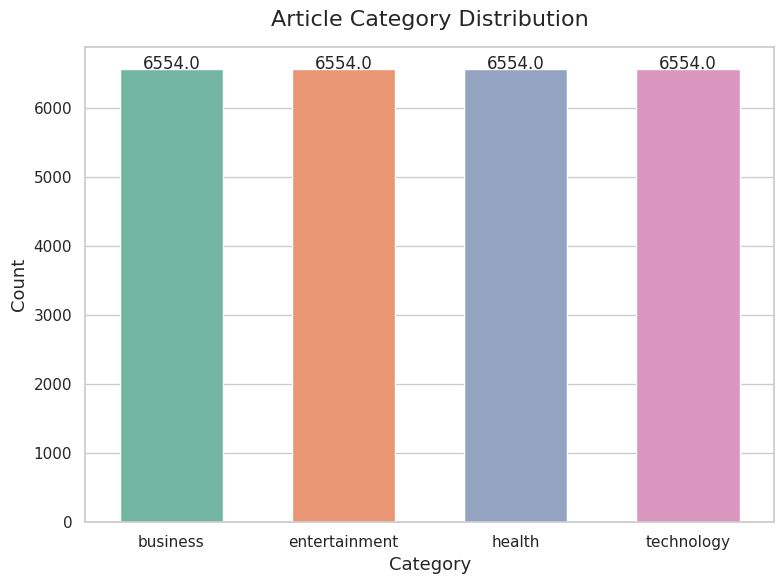

In [64]:
# Generate visualizations
plot_category_distribution(processed_df)

**WORDCLOUD VISUALIZATION**

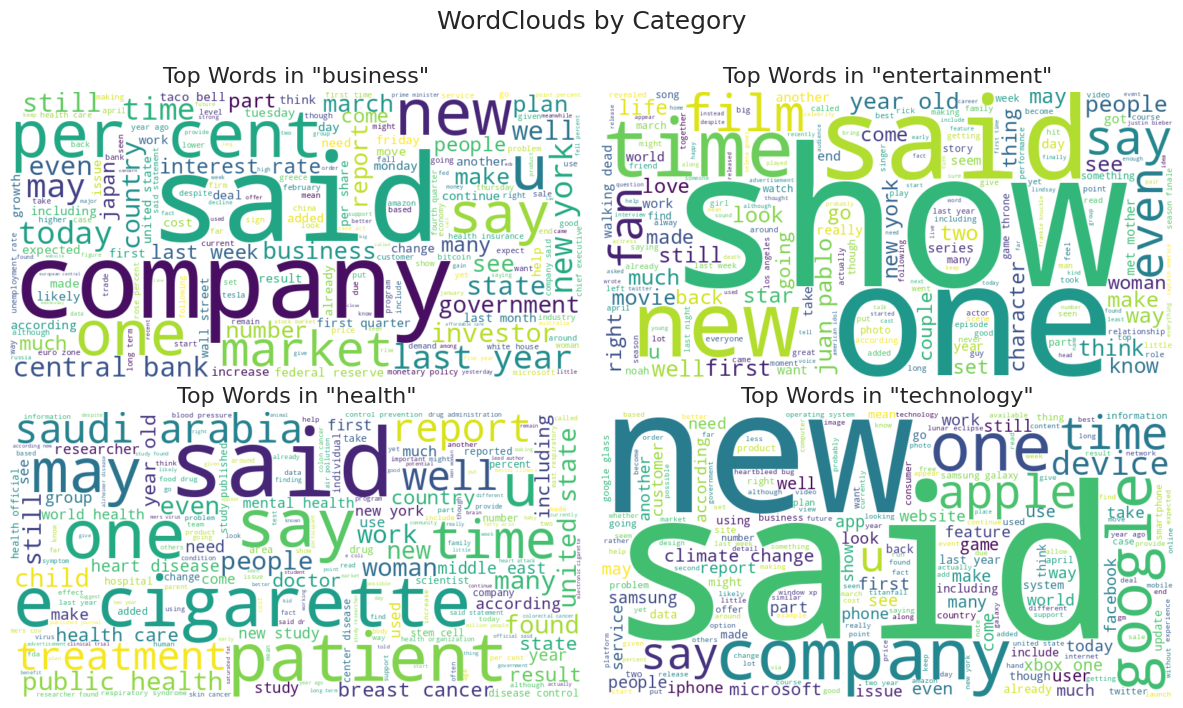

In [61]:
# Call the function
plot_wordclouds_grid(processed_df)

**Vsiualizing the top 2-word Phrases for the each category**

<ipython-input-62-c7b33bb1645c>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=labels, ax=axes[i], palette="mako", width=0.6)
<ipython-input-62-c7b33bb1645c>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=labels, ax=axes[i], palette="mako", width=0.6)
<ipython-input-62-c7b33bb1645c>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=labels, ax=axes[i], palette="mako", width=0.6)
<ipython-input-62-c7b33bb1645c>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be rem

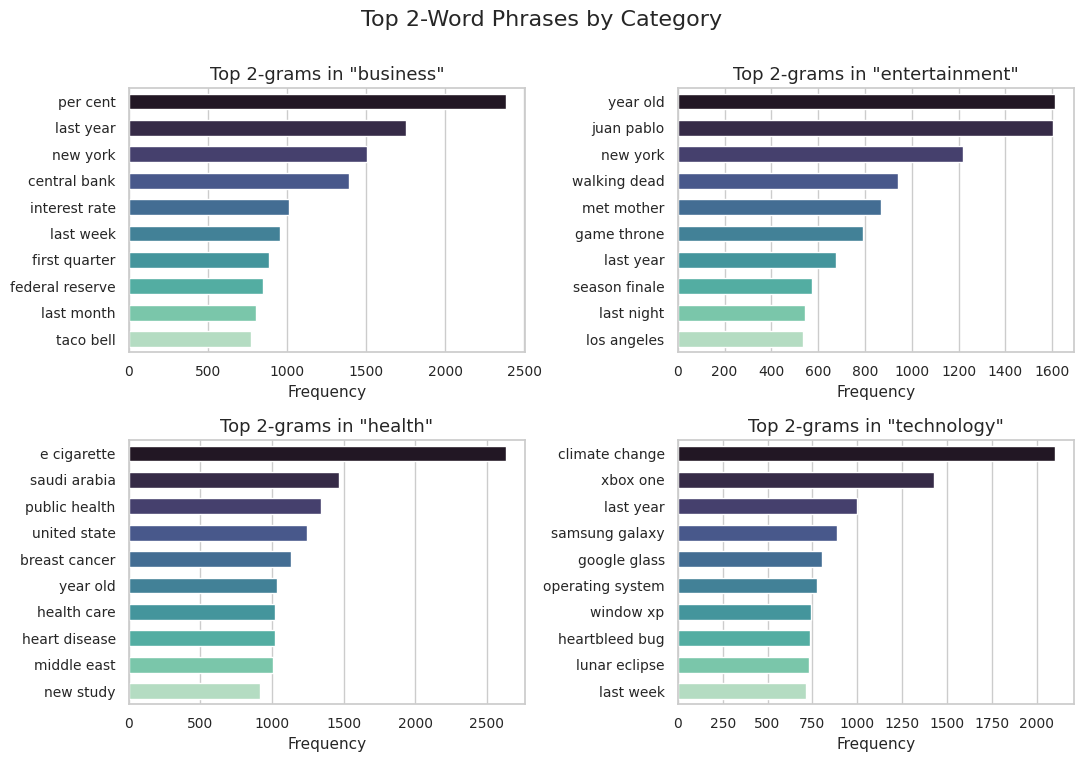

In [62]:

def plot_top_ngrams_grid(df, n=2, top_k=10):
    sns.set(style="whitegrid")
    categories = df['CATEGORY'].unique()
    num_cats = len(categories)

    # Set up 2x2 grid (adjust if categories != 4)
    fig, axes = plt.subplots(2, 2, figsize=(11, 8))
    axes = axes.flatten()

    for i, category in enumerate(categories):
        # Extract text and tokenize
        text = ' '.join(df[df['CATEGORY'] == category]['PROCESSED_CONTENT'])
        tokens = word_tokenize(text)
        n_grams = ngrams(tokens, n)
        freq_dist = Counter(n_grams).most_common(top_k)

        # Prepare data
        labels = [' '.join(gram) for gram, _ in freq_dist]
        counts = [count for _, count in freq_dist]

        # Plot
        sns.barplot(x=counts, y=labels, ax=axes[i], palette="mako", width=0.6)
        axes[i].set_title(f'Top {n}-grams in "{category}"', fontsize=13)
        axes[i].set_xlabel('Frequency', fontsize=11)
        axes[i].set_ylabel('')

        # Smaller ticks and spacing
        axes[i].tick_params(axis='y', labelsize=10)
        axes[i].tick_params(axis='x', labelsize=10)

    # Remove extra axes if categories < 4
    for j in range(i + 1, 4):
        fig.delaxes(axes[j])

    fig.suptitle(f'Top {n}-Word Phrases by Category', fontsize=16, y=0.95)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Call the function
plot_top_ngrams_grid(processed_df, n=2, top_k=10)


**Visualizing the top 15 Shared Words Across All Categories**

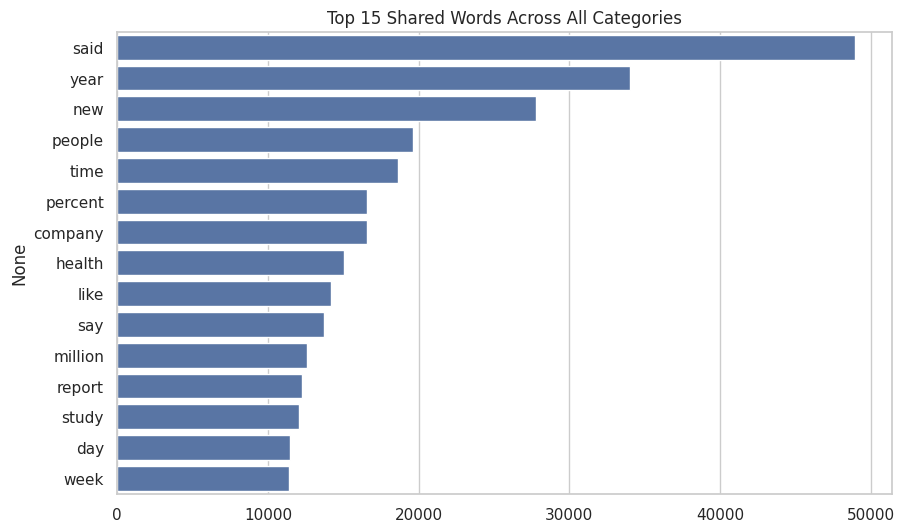

In [63]:
def plot_shared_words(df, top_k=15):
    vectorizer = CountVectorizer(stop_words='english')
    X = vectorizer.fit_transform(df.groupby('CATEGORY')['PROCESSED_CONTENT'].agg(' '.join))
    common_words = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out()).sum().nlargest(top_k)

    plt.figure(figsize=(10,6))
    sns.barplot(x=common_words.values, y=common_words.index)
    plt.title(f'Top {top_k} Shared Words Across All Categories')
    plt.show()

plot_shared_words(processed_df)

In [77]:
print("The shape of the scrapped data is: ", df.shape)
print("The shape of the processed data is: ", processed_df.shape)

The shape of the scrapped data is:  (33288, 3)
The shape of the processed data is:  (26216, 3)
